In [120]:
# MANIPULAÇÃO DE DADOS
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# ML - MÉTRICAS
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_predict, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.decomposition import PCA

# ALGORÍTIMOS
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor
from sklearn.svm import SVC

# VISUALIZAÇÃO
import matplotlib.pyplot as plt
import seaborn as sns

import locale
import warnings
warnings.filterwarnings("ignore")

# Funções de apoio

In [69]:
def analise_por_coluna(df: pd.DataFrame):

    analise_geral = []

    for col in df.columns:
        col_data = {
            'Coluna': col,
            'Registros': df[col].count(),
            'Nulos': df[col].isnull().sum(),
            'Perc Nulos': (df[col].isnull().sum() / df.shape[0]) * 100,
            'Registro únicos': df[col].nunique(),
            'Valor mais frequente': df[col].mode()[0] if not df[col].mode().empty else None,
            'Frequência do valor mais comum': df[col].value_counts().max() if not df[col].value_counts().empty else None,
            'Tipo dado': df[col].dtype
        }

        analise_geral.append(col_data)
    return pd.DataFrame(analise_geral)

* Métrica do coeficiente de concordância de correlação (CCC)

In [ ]:
def concordance_correlation_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    return (2 * cov) / (var_true + var_pred + (mean_true - mean_pred) ** 2)

* Função de parametrização de lags para usar na predição

In [107]:
def create_lag_features(df, lags=[1, 2, 3], col_target='item_cnt_month'):
    df_lag = df.copy()
    for lag in lags:
        lagged = df[['shop_id', 'item_id', 'date_block_num', col_target]].copy()
        lagged['date_block_num'] += lag
        lagged = lagged.rename(columns={col_target: f'{col_target}_lag_{lag}'})
        df_lag = df_lag.merge(lagged, on=['shop_id', 'item_id', 'date_block_num'], how='left')
    return df_lag
df_mes_lags = create_lag_features(df_mes, lags=[1, 2, 3])
df_mes_lags.fillna(0, inplace=True)

* GridSearch para o XGBOOST

In [ ]:
def ajustar_xgboost_com_grid(X, y, cv, verbose=True):
    param_grid = {
        'n_estimators': [100, 300],
        'learning_rate': [0.05, 0.1],
        'max_depth': [4, 6],
        'subsample': [0.8, 1.0]
    }

    xgb = XGBRegressor(random_state=42)

    grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X, y)

    if verbose:
        print(f"GridSearch XGBoost - Melhor RMSE: {-grid.best_score_:.4f}")
        print(f"Melhores parâmetros: {grid.best_params_}")

    return grid.best_estimator_

* Avaliação de modelos

In [137]:
def avaliar_modelos(X, y, modelos, n_splits=5, verbose=True):
    resultados = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for nome, modelo in modelos.items():
        if verbose: print(f"\n Avaliando modelo: {nome}")

        if nome == 'XGBoost':
            modelo = ajustar_xgboost_com_grid(X, y, tscv, verbose=verbose)

        y_true_all = []
        y_pred_all = []

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
            y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

            modelo.fit(X_train_cv, y_train_cv)
            y_pred_cv = modelo.predict(X_val_cv)

            y_true_all.extend(y_val_cv)
            y_pred_all.extend(y_pred_cv)

        # Conversão e truncagem
        y_true_all = np.array(y_true_all)
        y_pred_all = np.clip(np.array(y_pred_all), 0, 20)

        # Métricas
        rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
        mae = mean_absolute_error(y_true_all, y_pred_all)
        r2 = r2_score(y_true_all, y_pred_all)
        mape = np.mean(np.abs((y_true_all - y_pred_all) / (y_true_all + 1e-5))) * 100
        ccc = concordance_correlation_coefficient(y_true_all, y_pred_all)

        resultados.append({
            'Modelo': nome,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R²': r2,
            'CCC': ccc
        })

        # Gráfico Real vs Predito
        plt.figure(figsize=(5, 5))
        sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.3)
        plt.plot([0, 20], [0, 20], color='red', linestyle='--')
        plt.title(f'Real vs Predito - {nome}')
        plt.xlabel('Valor Real')
        plt.ylabel('Predição')
        plt.grid(True)
        plt.xlim(0, 20)
        plt.ylim(0, 20)
        plt.tight_layout()
        plt.show()

    df_resultados = pd.DataFrame(resultados).sort_values(by='RMSE')
    
    if verbose:
        print("\nResumo de Desempenho dos Modelos:")
        display(df_resultados)

    # Identificar o melhor modelo
    nome_melhor = df_resultados.iloc[0]['Modelo']
    melhor_modelo = modelos[nome_melhor]

    print(f" Melhor modelo: {nome_melhor}")

    return df_resultados, nome_melhor, melhor_modelo


* Gerar previsões

In [138]:
def gerar_previsoes_com_melhor_modelo(df_test, df_features, modelo_avaliado, features_usadas, nome_arquivo='previsoes.csv'):

    df_test = df_test.copy()
    df_test['date_block_num'] = 34  # mês de previsão

    df_merged = df_test.merge(
        df_features[df_features['date_block_num'] == 34],
        on=['shop_id', 'item_id', 'date_block_num'],
        how='left'
    )

    X_test = df_merged[features_usadas].fillna(0)

    # Predição
    y_pred = modelo_avaliado.predict(X_test)
    y_pred = np.clip(y_pred, 0, 20)  # regra do desafio

    df_submissao = pd.DataFrame({
        'ID': df_test['ID'],
        'item_cnt_month': y_pred
    })

    df_submissao.to_csv(nome_arquivo, index=False)
    print(f" Arquivo '{nome_arquivo}' gerado com sucesso com o melhor modelo!")

    return df_submissao

# importando dados

In [128]:
X_train = pd.read_csv("../dados/sales_train.csv")
test = pd.read_csv("../dados/test.csv")

# Tabelas de apoio - dados extras
df_items = pd.read_csv('../dados/items.csv')
df_item_categories = pd.read_csv('../dados/item_categories.csv')
df_shops = pd.read_csv('../dados/shops.csv')

X_train.sample(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1222632,10.12.2013,11,58,17481,999.0,1.0
1199103,12.12.2013,11,53,4886,899.0,1.0
2556561,23.04.2015,27,28,1556,2999.0,1.0
104959,29.01.2013,0,41,19789,249.0,1.0
279398,23.03.2013,2,18,3705,1499.0,1.0
1993039,29.09.2014,20,30,15041,1999.0,1.0
2786576,09.08.2015,31,41,19659,399.0,1.0
1832957,05.07.2014,18,16,16184,249.0,1.0
2335809,02.01.2015,24,4,17717,272.0,1.0
2758010,29.07.2015,30,26,4870,1299.0,1.0


# EDA - Análise exploratória de dados

In [71]:
X_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [72]:
visao_geral_base = analise_por_coluna(X_train)
visao_geral_base

,Coluna,Registros,Nulos,Perc Nulos,Registro únicos,Valor mais frequente,Frequência do valor mais comum,Tipo dado
0,date,2935849,0,0.0,1034,28.12.2013,9434,object
1,date_block_num,2935849,0,0.0,34,11,143246,int64
2,shop_id,2935849,0,0.0,60,31,235636,int64
3,item_id,2935849,0,0.0,21807,20949,31340,int64
4,item_price,2935849,0,0.0,19993,299.0,291352,float64
5,item_cnt_day,2935849,0,0.0,198,1.0,2629372,float64


* Considerações iniciais
    * não há registros nulos
    * 21.807 produtos únicos. O item mais vendido: ID 20949.
    * 19.993 preços únicos, (Avaliar outliers). Valor mais comum: 299.0
    * 198 valores únicos. Valor mais comum: 1 unidade vendida por dia

---

# Manipulação de dados - engenharia de feature

* Transformando o dataset na visão mês

In [73]:
X_train['date'] = pd.to_datetime(X_train['date'], format='%d.%m.%Y')
X_train['ano_mes'] = X_train['date'].dt.to_period('M').astype(str)

df_mes = (
    X_train.groupby(['ano_mes', 'shop_id', 'item_id'], as_index=False)
           .agg({'item_cnt_day': 'sum'})
           .rename(columns={'item_cnt_day': 'item_cnt_month'})
)

df_mes.sample(5)

,ano_mes,shop_id,item_id,item_cnt_month
378221,2013-07,29,16668,1.0
1303822,2015-02,5,5010,1.0
365,2013-01,0,4147,5.0
1087568,2014-09,31,17625,1.0
963361,2014-06,49,1075,1.0


In [74]:
map_block = (
    X_train[['date_block_num', 'ano_mes']]
    .drop_duplicates()
    .sort_values('date_block_num')
)

df_mes = df_mes.merge(map_block, on='ano_mes', how='left')
df_mes.sample(5)

,ano_mes,shop_id,item_id,item_cnt_month,date_block_num
1299140,2015-01,57,6084,1.0,24
675894,2013-12,53,5210,4.0,11
1011919,2014-07,52,15022,1.0,18
1233786,2014-12,42,7872,2.0,23
292833,2013-05,57,20169,1.0,4


* União do nome dos produtos e categoria no dataset mensal

In [75]:
df_mes = df_mes.merge(df_items, on='item_id', how='left')
df_mes = df_mes.merge(df_item_categories, on='item_category_id', how='left')

df_mes[['item_id', 'item_name', 'item_category_id', 'item_category_name']].sample(5)

,item_id,item_name,item_category_id,item_category_name
1500611,5323,ONE DIRECTION Midnight Memories,55,Музыка - CD локального производства
1092410,5677,PS4: Подставка 4gamers Stand 'n' USB Hub верти...,3,Аксессуары - PS4
482810,3267,FABIAN LARA A Wonderful Life,55,Музыка - CD локального производства
415326,2626,DION CELINE My Love Essential Collection,55,Музыка - CD локального производства
293713,11645,ЗАЩИТНИК (BD),37,Кино - Blu-Ray


* Trazer a localização das lojas

In [76]:
df_mes = df_mes.merge(df_shops, on='shop_id', how='left')
df_mes[['shop_id', 'shop_name']].drop_duplicates()
df_mes.sample(5)

,ano_mes,shop_id,item_id,item_cnt_month,date_block_num,item_name,item_category_id,item_category_name,shop_name
1247618,2014-12,54,12118,2.0,23,"Игровая консоль ""Microsoft Xbox One 500GB"" + ""...",16,Игровые консоли - XBOX ONE,"Химки ТЦ ""Мега"""
1169751,2014-11,29,10502,1.0,22,ГРАДУСЫ Чувство ловкости,55,Музыка - CD локального производства,"Москва ТЦ ""Новый век"" (Новокосино)"
566013,2013-10,57,3676,8.0,9,Gears of War 3 Xbox 360 PL/RU PAL DVD (D9D-00...,23,Игры - XBOX 360,"Якутск Орджоникидзе, 56"
955272,2014-06,38,10502,1.0,17,ГРАДУСЫ Чувство ловкости,55,Музыка - CD локального производства,"Омск ТЦ ""Мега"""
104593,2013-02,38,4827,7.0,1,"Metal Gear Rising: Revengeance [PS3, русская д...",19,Игры - PS3,"Омск ТЦ ""Мега"""


# EDA - Análise exploratória de dados + Feature engineering

* Distribuição da variável target (item_cnt_month)

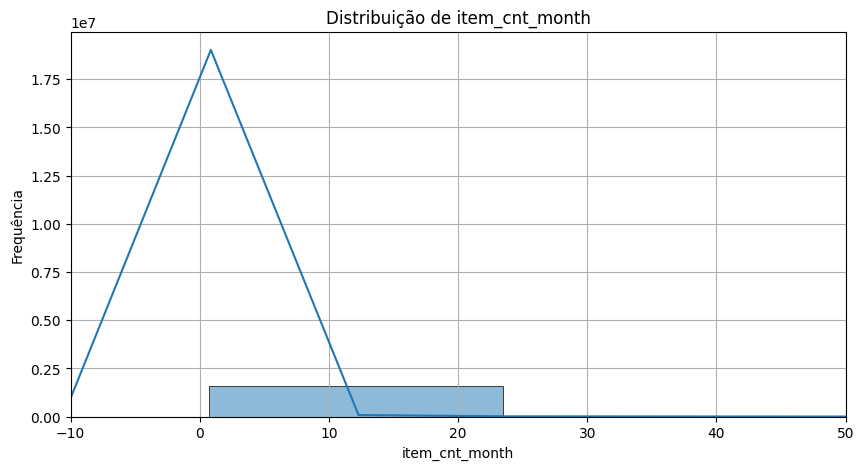

In [77]:
plt.figure(figsize=(10, 5))
sns.histplot(df_mes['item_cnt_month'], bins=100, kde=True)
plt.title('Distribuição de item_cnt_month')
plt.xlabel('item_cnt_month')
plt.ylabel('Frequência')
plt.xlim(-10, 50)
plt.grid(True)
plt.show()

* Considerações:
    * Valores baixos já esperado, pois a maioria dos produtos vendem pouco por mês
    * Distribuição altamente assimétrica à direita (right-skewed)
    * Há valores negativos e valores maiores que 20. ( Tratar )

In [78]:
print(f"total de calores: {df_mes['item_cnt_month'].count()}")
print(f"Valores negativos: {sum(df_mes['item_cnt_month'] < 0)}")
print(f"Valores acima de 20: {sum(df_mes['item_cnt_month'] > 20)}")

total de calores: 1609124
Valores negativos: 915
Valores acima de 20: 11463


* Supeitei que valores negativos sejam devoluções se tratando de vendas, decidi avaliar se estou certo, pois o fato de tratar esses valores faria com que eu mantivesse os valores positivos não refletindo a realidade

In [79]:
df_devolucoes = X_train[X_train['item_cnt_day'] < 0]
df_compras = X_train[X_train['item_cnt_day'] > 0]

df_join = df_devolucoes.merge(
    df_compras,
    on=['date', 'shop_id', 'item_id'],
    suffixes=('_dev', '_comp')
)

print(f"Total de devoluções com venda correspondente no mesmo dia: {len(df_join)}")

Total de devoluções com venda correspondente no mesmo dia: 2


* A maioria das devoluções não está ligada diretamente a uma venda no mesmo dia.
    * Neste caso decidi por tratar devoluções como 0 (sem venda efetiva no mês)

In [80]:
# Tratar devoluções como 0
df_mes.loc[df_mes['item_cnt_month'] < 0, 'item_cnt_month'] = 0

* O desafio pede pra clipar os valores até 20:
 * "The target value (number of items sold per month) will be capped between 0 and 20 in the final evaluation metric (RMSE)."
 * Mesmo o desafio já pedindo isso, tomei a liberdade para analisar o motivo, em um cenário real pode ser leaked data.

In [81]:
df_mes['item_cnt_month'] = df_mes['item_cnt_month'].clip(0, 20)

---

* Evolução mensal do volume de vendas

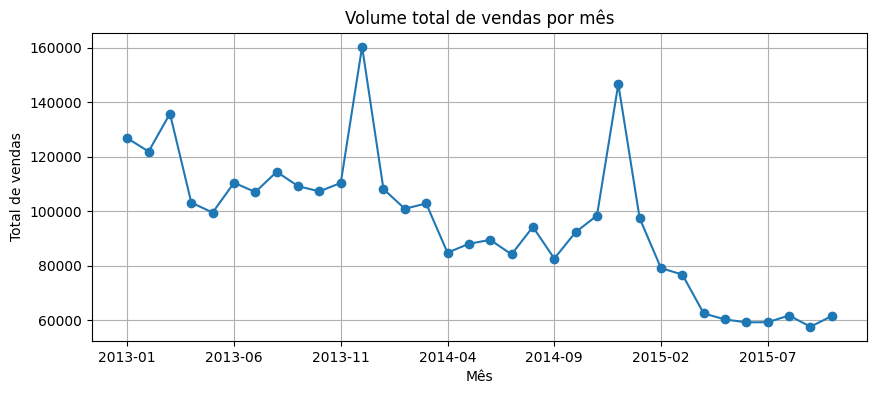

In [82]:
vendas_por_mes = df_mes.groupby('ano_mes')['item_cnt_month'].sum()

plt.figure(figsize=(10, 4))
vendas_por_mes.plot(marker='o')
plt.title('Volume total de vendas por mês')
plt.xlabel('Mês')
plt.ylabel('Total de vendas')
plt.grid(True)
plt.show()

* Considerações:
    * Dezembro/2013 e Dezembro/2014 são picos de vendas altíssimos (Pode ser o efeito Natal).
    * Tendência geral de queda ao longo dos meses, principalmente a partir de 2015.


* Ajustando features para modelagem, poderia fazer depois, mas já que estou aqui kk

    * Modelos como XGBoost, LightGBM, Random Forest etc., não sabem o que é Natal, nem mês.
        * Eles só sabem: "Quando is_december == 1, a demanda costuma subir."

    * Essa nova flag que vou criar permite ao modelo:
        * Aprender que novembro → dezembro tem salto na demanda
        * Ajustar a previsão sem precisar entender datas reais
        * Fazer isso de forma simples, sem misturar mês == 12 com ano

In [83]:
if 'ano_mes' not in df_mes.columns:
    raise ValueError("df_mes precisa ter a coluna 'ano_mes' para esse merge funcionar.")

df_mes['ano_mes'] = df_mes['ano_mes'].astype(str)
X_train['ano_mes'] = X_train['ano_mes'].astype(str)

calendar_map = (
    X_train[['ano_mes', 'date_block_num', 'date']]
    .drop_duplicates(subset='ano_mes')
    .sort_values('ano_mes')
    .copy()
)

calendar_map['date'] = pd.to_datetime(calendar_map['date'])
calendar_map['month'] = calendar_map['date'].dt.month
calendar_map['year'] = calendar_map['date'].dt.year
calendar_map['dezembro'] = (calendar_map['month'] == 12).astype(int)

calendar_map = calendar_map[['ano_mes', 'date_block_num', 'month', 'year', 'dezembro']]

print("Prévia do calendar_map:")
print(calendar_map.head())

Prévia do calendar_map:
        ano_mes  date_block_num  month  year  dezembro
0       2013-01               0      1  2013         0
115690  2013-02               1      2  2013         0
224303  2013-03               2      3  2013         0
345650  2013-04               3      4  2013         0
439759  2013-05               4      5  2013         0


* Mesclagem

In [84]:
df_mes = df_mes.drop(columns=['date_block_num'], errors='ignore')
df_mes = df_mes.merge(calendar_map, on='ano_mes', how='left')
print("Colunas após o merge:", df_mes.columns)

df_mes[['ano_mes', 'date_block_num', 'month', 'year', 'dezembro']] \
    .drop_duplicates() \
    .sort_values('ano_mes') \
    .sample(5)

Colunas após o merge: Index(['ano_mes', 'shop_id', 'item_id', 'item_cnt_month', 'item_name',
       'item_category_id', 'item_category_name', 'shop_name', 'date_block_num',
       'month', 'year', 'dezembro'],
      dtype='object')


,ano_mes,date_block_num,month,year,dezembro
1343434,2015-03,26,3,2015,0
838039,2014-04,15,4,2014,0
241774,2013-05,4,5,2013,0
1577593,2015-10,33,10,2015,0
1107644,2014-10,21,10,2014,0


---

* Produtos mais vendidos

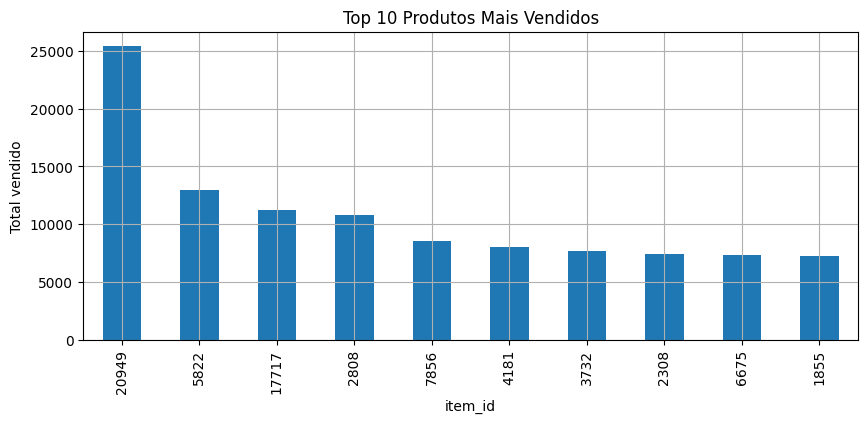

In [85]:
top_produtos = df_mes.groupby('item_id')['item_cnt_month'].sum().sort_values(ascending=False).head(10)
top_produtos.plot(kind='bar', figsize=(10,4), title='Top 10 Produtos Mais Vendidos')
plt.ylabel('Total vendido')
plt.grid(True)
plt.show()

* Considerações:
    * O item 20949 Tem mais de 180.000 unidades vendidas ou é outlier ou produto carro-chefe.

* Ideia:
 
 * Nem todos os produtos são iguais:
    * Alguns vendem todo mês em várias lojas, utros quase nunca vendem e alguns aparecem muito (como o item_id 20949)

    * Se não dermos essa informação ao modelo, ele pode tratar todos os itens como se tivessem a mesma probabilidade de venda — o que reduz muito a precisão.

In [86]:
# Vou pegar o total de vendas por item/produto

total_vendas_produto = (
    df_mes.groupby('item_id')['item_cnt_month']
    .sum()
    .sort_values(ascending=False)
    .rename('total_vendas_produto')
)
df_mes = df_mes.merge(total_vendas_produto, on='item_id', how='left')

In [87]:
# Identificar os top mais vendidos
top_n = 10
top_produtos_vendas = total_vendas_produto.head(top_n).index

# Criar flag binária no df (me ajudar no modelo)
df_mes['top_produtos_vendas'] = df_mes['item_id'].isin(top_produtos_vendas).astype(int)

---

* Lojas com maior volume de vendas

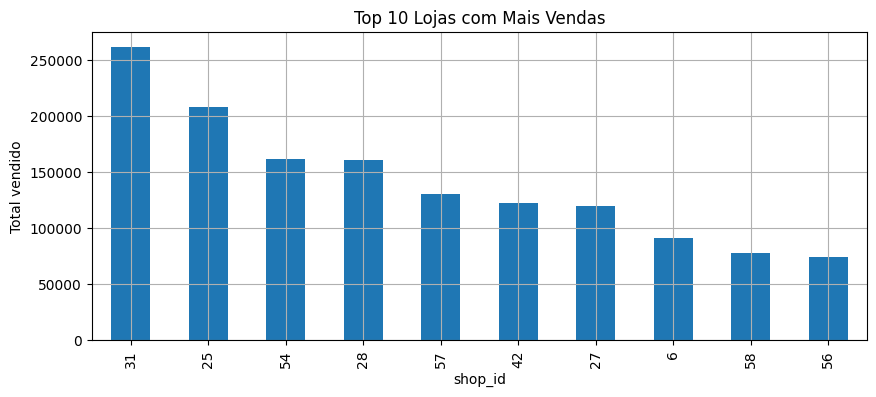

In [88]:
top_lojas = df_mes.groupby('shop_id')['item_cnt_month'].sum().sort_values(ascending=False).head(10)
top_lojas.plot(kind='bar', figsize=(10,4), title='Top 10 Lojas com Mais Vendas')
plt.ylabel('Total vendido')
plt.grid(True)
plt.show()

* Ideia:
    
    * Aprender que certas lojas vendem bem independente do produto
    * Reduzir a chance de prever vendas em lojas “mortas”

* Criar variáveis que peguem o comportamento da loja robustece meu modelo:
 * Total_vendas_por_loja =	variável contínua que ajuda a Medir potencial da loja com base em histórico
 * Lojas_que_mais_vendem (talvez) = variável binária que ajuda a Marcar lojas dominantes

In [89]:
total_vendas_por_loja = (
    df_mes.groupby('shop_id')['item_cnt_month']
    .sum()
    .sort_values(ascending=False)
    .rename('total_vendas_por_loja')
)
df_mes = df_mes.merge(total_vendas_por_loja, on='shop_id', how='left')

* Caso eu tenha o mesmo produto o comportamento pode ser muito diferente dependendo da loja. O modelo pode aprender isso!

----

* Vendas por categoria

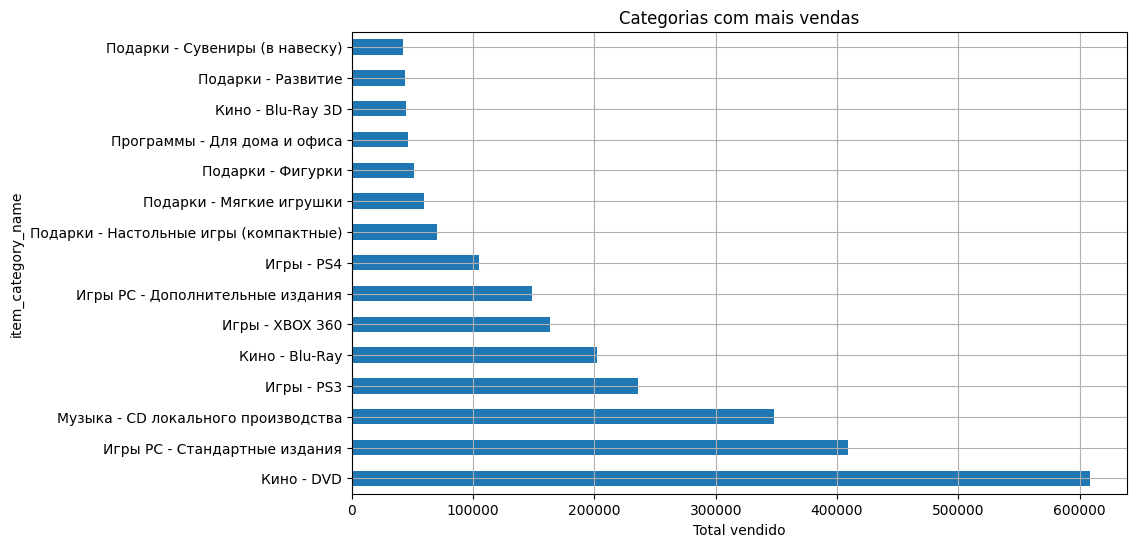

In [90]:
cat_vendas = df_mes.groupby('item_category_name')['item_cnt_month'].sum().sort_values(ascending=False).head(15)
cat_vendas.plot(kind='barh', figsize=(10,6), title='Categorias com mais vendas')
plt.xlabel('Total vendido')
plt.grid(True)
plt.show()

* Seguindo o mesmo pressuposto:

    * Criar features que ajudem o modelo a entender:
        * Quais categorias têm alta demanda
        * Se o item pertence a uma categoria com peso comercial significativo

In [91]:
total_vendas_cat = (
    df_mes.groupby('item_category_id')['item_cnt_month']
    .sum()
    .sort_values(ascending=False)
    .rename('total_vendas_cat')
)
df_mes = df_mes.merge(total_vendas_cat, on='item_category_id', how='left')

# Análise de correlação

In [92]:
df_mes.columns

Index(['ano_mes', 'shop_id', 'item_id', 'item_cnt_month', 'item_name',
       'item_category_id', 'item_category_name', 'shop_name', 'date_block_num',
       'month', 'year', 'dezembro', 'total_vendas_produto',
       'top_produtos_vendas', 'total_vendas_por_loja', 'total_vendas_cat'],
      dtype='object')

In [93]:
numericas = df_mes.select_dtypes(include=['int64', 'float64'])
correlacoes = numericas.corr()['item_cnt_month'].sort_values(ascending=False)

print("Correlação com item_cnt_month:")
print(correlacoes)

Correlação com item_cnt_month:
item_cnt_month           1.000000
total_vendas_produto     0.413428
top_produtos_vendas      0.234798
total_vendas_por_loja    0.096113
dezembro                 0.047608
shop_id                  0.004827
date_block_num          -0.006509
total_vendas_cat        -0.029943
item_id                 -0.078788
item_category_id        -0.089494
Name: item_cnt_month, dtype: float64


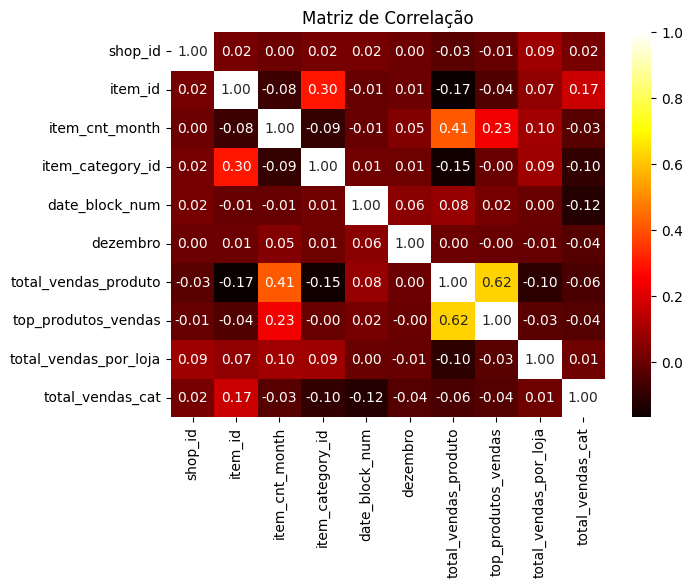

In [94]:
plt.figure(figsize=(7, 5))
sns.heatmap(numericas.corr(), annot=True, fmt=".2f", cmap="hot")
plt.title("Matriz de Correlação")
plt.show()

* Considerações sobre as variáveis:

    * total_vendas_produto	- 0.41	= Forte indicativo que produtos com alto histórico de venda continuam vendendo bem. Boa feature.
    * top_produtos_vendas	- 0.23	= Produtos "campeões" vendem mais, como esperado.
    * total_vendas_por_loja	- 0.10	= Lojas mais fortes vendem mais, mas com influência mais leve.
    * dezembro	            - 0.05	= Efeito natalino existe, mas impacta poucos produtos.
    * date_block_num	    --0.01	= Não tem relação direta, mas será útil para lags e tendências

# MODELAGEM

* CONJUNTO DE TREINO E VALIDAÇÃO

In [112]:
df_train = df_mes_lags[df_mes_lags['date_block_num'] < 33].copy()
df_val   = df_mes_lags[df_mes_lags['date_block_num'] == 33].copy()

* Seleção de features

In [113]:
features_numericas = df_mes_lags.select_dtypes(include=['int64', 'float64']).columns.tolist()

features_numericas.remove('item_cnt_month')
print("Features numéricas para modelagem:", features_numericas)

Features numéricas para modelagem: ['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'dezembro', 'total_vendas_produto', 'top_produtos_vendas', 'total_vendas_por_loja', 'total_vendas_cat', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']


In [123]:
X = df_train[features_numericas].fillna(0)
y = df_train['item_cnt_month']
y = df_train['item_cnt_month'].astype('float32')

* Validação cruzada

In [124]:
tscv = TimeSeriesSplit(n_splits=5)

In [125]:
modelos = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
}

# Resultados


 Avaliando modelo: LinearRegression


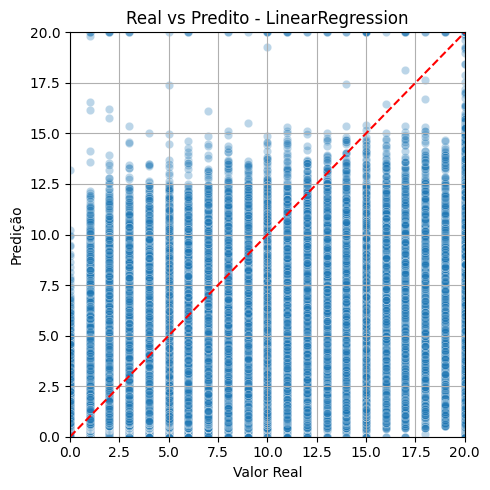


 Avaliando modelo: RandomForest


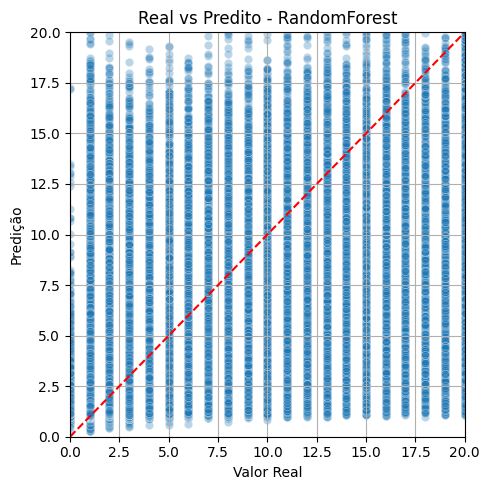


 Avaliando modelo: XGBoost
GridSearch XGBoost - Melhor RMSE: 1.9103
Melhores parâmetros: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


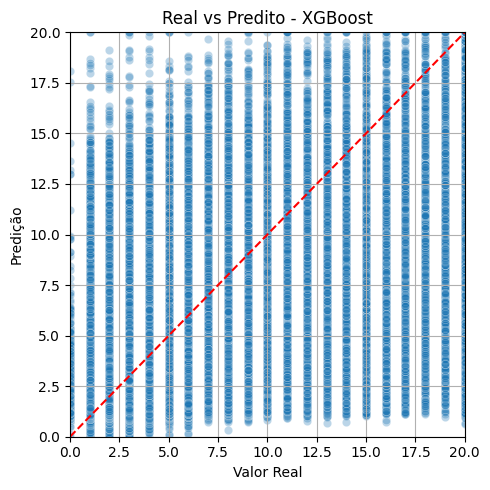


Resumo de Desempenho dos Modelos:


,Modelo,RMSE,MAE,MAPE,R²,CCC
2,XGBoost,1.913436,0.967045,36770.783512,0.451733,0.631665
1,RandomForest,1.995905,1.026889,39240.472696,0.403454,0.616321
0,LinearRegression,2.137461,1.041025,32971.838349,0.315836,0.510502


🏆 Melhor modelo: XGBoost


In [136]:
resultados, nome_melhor, melhor_modelo = avaliar_modelos(X, y, modelos)

# Previsão

In [140]:
test = pd.read_csv("../dados/test.csv") 

In [142]:
melhor_modelo.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [143]:
gerar_previsoes_com_melhor_modelo(
    df_test=test,
    df_features=df_mes_lags,
    modelo_avaliado=melhor_modelo,
    features_usadas=features_numericas,
    nome_arquivo='previsoes.csv'
)

 Arquivo 'previsoes.csv' gerado com sucesso com o melhor modelo!


,ID,item_cnt_month
0,0,0.948816
1,1,0.948816
2,2,0.948816
3,3,0.948816
4,4,0.948816
...,...,...
214195,214195,0.697894
214196,214196,0.691196
214197,214197,0.698211
214198,214198,0.697894
